<a href="https://colab.research.google.com/github/tanveerTFF/SyntheticMRI_ImageGeneration_WithGAN/blob/main/SyntheticMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#190021108 190021111 190021128
# Install the Kaggle API
!pip install kaggle

# Upload Kaggle API key file (kaggle.json)
from google.colab import files
files.upload()

# Move the uploaded kaggle.json file to the appropriate directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set appropriate permissions for the Kaggle API key file
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset using the Kaggle API
!kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset

# Unzip the downloaded file
!unzip alzheimer-mri-dataset.zip -d alzheimer_mri_dataset

Streaming output truncated to the last 5000 lines.
  inflating: alzheimer_mri_dataset/Dataset/Non_Demented/non_1395.jpg  
  inflating: alzheimer_mri_dataset/Dataset/Non_Demented/non_1396.jpg  
  inflating: alzheimer_mri_dataset/Dataset/Non_Demented/non_1397.jpg  
  inflating: alzheimer_mri_dataset/Dataset/Non_Demented/non_1398.jpg  
  inflating: alzheimer_mri_dataset/Dataset/Non_Demented/non_1399.jpg  
  inflating: alzheimer_mri_dataset/Dataset/Non_Demented/non_14.jpg  
  inflating: alzheimer_mri_dataset/Dataset/Non_Demented/non_140.jpg  
  inflating: alzheimer_mri_dataset/Dataset/Non_Demented/non_1400.jpg  
  inflating: alzheimer_mri_dataset/Dataset/Non_Demented/non_1401.jpg  
  inflating: alzheimer_mri_dataset/Dataset/Non_Demented/non_1402.jpg  
  inflating: alzheimer_mri_dataset/Dataset/Non_Demented/non_1403.jpg  
  inflating: alzheimer_mri_dataset/Dataset/Non_Demented/non_1404.jpg  
  inflating: alzheimer_mri_dataset/Dataset/Non_Demented/non_1405.jpg  
  inflating: alzheimer_mri_da

In [2]:
!pip install torch torchvision
!pip install Pillow
!pip install numpy


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [3]:
import os
# Create a folder for saving generated images
os.makedirs("generated_images", exist_ok=True)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import os
from PIL import Image
import numpy as np

# Define the Generator network
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, np.prod(img_shape)),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

# Define the Discriminator network
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(np.prod(img_shape), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

In [5]:

# Define custom dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)

    def __len__(self):
        return sum([len(os.listdir(os.path.join(self.root_dir, cls))) for cls in self.classes])

    def __getitem__(self, idx):
        img_class = np.random.choice(self.classes)
        img_name = np.random.choice(os.listdir(os.path.join(self.root_dir, img_class)))
        img_path = os.path.join(self.root_dir, img_class, img_name)
        image = Image.open(img_path)

        # Resize image to target size and convert to tensor
        if self.transform:
            image = self.transform(image)

        return image

In [6]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
latent_dim = 100
img_shape = (3, 64, 64)  # Change dimensions as per your image size
lr = 0.0002
batch_size = 64
epochs = 50

# Initialize generator and discriminator
generator = Generator(latent_dim, img_shape).to(device)
discriminator = Discriminator(img_shape).to(device)

# Define loss function and optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Initialize dataset and dataloader with grayscale normalization
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for grayscale
])
dataset = CustomDataset(root_dir="/content/alzheimer_mri_dataset/Dataset", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:

# Training loop
for epoch in range(epochs):
    for i, imgs in enumerate(dataloader):
        real_imgs = imgs.to(device)

        # Train discriminator
        optimizer_D.zero_grad()

        # Generate fake images
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        fake_imgs = generator(z)

        # Train discriminator with real images
        real_labels = torch.ones(imgs.size(0), 1).to(device)
        real_pred = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, real_labels)

        # Train discriminator with fake images
        fake_labels = torch.zeros(imgs.size(0), 1).to(device)
        fake_pred = discriminator(fake_imgs.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake_labels)

        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train generator
        optimizer_G.zero_grad()

        # Generate fake images
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        fake_imgs = generator(z)

        # Get discriminator's prediction on fake images
        validity = discriminator(fake_imgs)

        # Generator loss
        g_loss = adversarial_loss(validity, real_labels)
        g_loss.backward()
        optimizer_G.step()

        # Print progress
        batches_done = epoch * len(dataloader) + i
        if batches_done % 400 == 0:
            print(
                f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] "
                f"[D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}]"
            )

    # Save generated images at the end of each epoch
    if epoch % 5 == 0:
        save_image(fake_imgs.data[:25], f"generated_images/{epoch}.png", nrow=5, normalize=True)


[Epoch 0/50] [Batch 0/100] [D loss: 0.707370] [G loss: 0.855695]
[Epoch 4/50] [Batch 0/100] [D loss: 0.563820] [G loss: 0.673320]
[Epoch 8/50] [Batch 0/100] [D loss: 0.579865] [G loss: 1.052207]
[Epoch 12/50] [Batch 0/100] [D loss: 0.625469] [G loss: 1.203342]
[Epoch 16/50] [Batch 0/100] [D loss: 0.631290] [G loss: 1.069787]
[Epoch 20/50] [Batch 0/100] [D loss: 0.625662] [G loss: 0.857876]
[Epoch 24/50] [Batch 0/100] [D loss: 0.611373] [G loss: 0.697317]
[Epoch 28/50] [Batch 0/100] [D loss: 0.649371] [G loss: 0.835267]
[Epoch 32/50] [Batch 0/100] [D loss: 0.742273] [G loss: 1.044346]
[Epoch 36/50] [Batch 0/100] [D loss: 0.577041] [G loss: 1.303617]
[Epoch 40/50] [Batch 0/100] [D loss: 0.619121] [G loss: 0.924981]
[Epoch 44/50] [Batch 0/100] [D loss: 0.593230] [G loss: 1.043725]
[Epoch 48/50] [Batch 0/100] [D loss: 0.587793] [G loss: 1.023155]


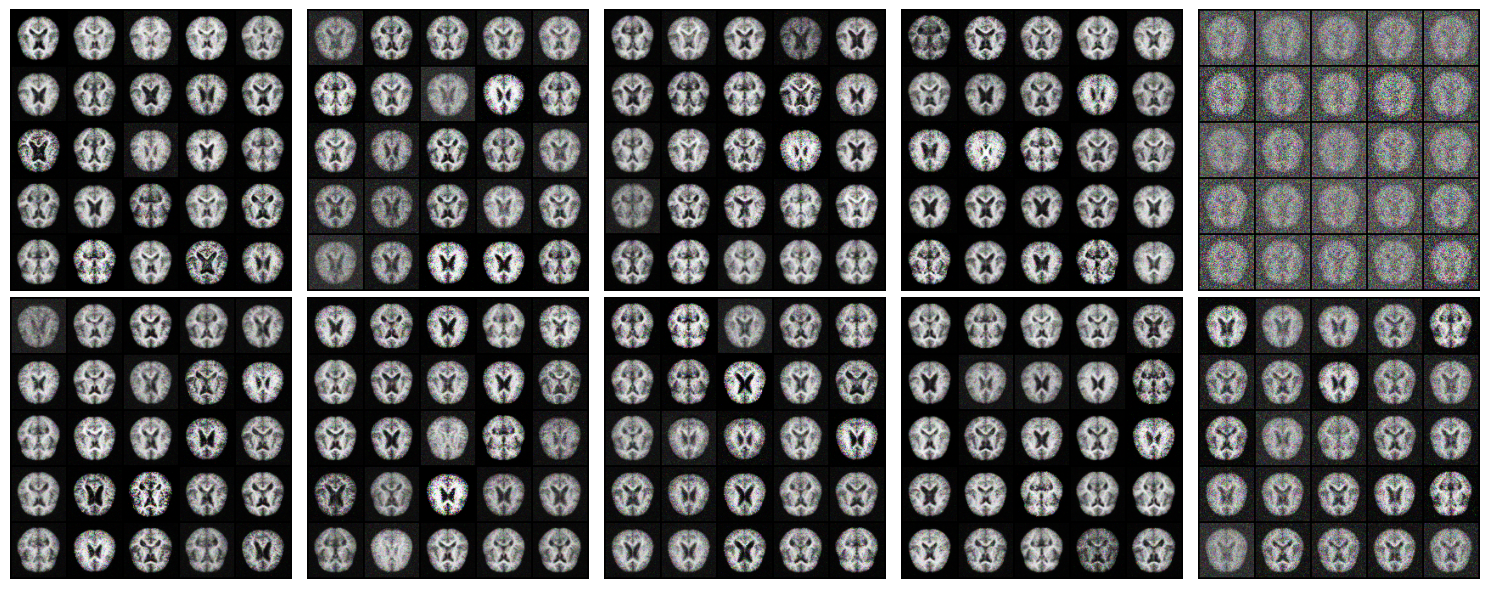

In [8]:
import matplotlib.pyplot as plt
import os

# Directory containing the generated images
output_dir = "generated_images"

# List all image files in the directory
image_files = [f for f in os.listdir(output_dir) if os.path.isfile(os.path.join(output_dir, f))]

# Display the generated images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    # Load and display the image
    img_path = os.path.join(output_dir, image_files[i])
    img = plt.imread(img_path)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()
